# Fully-Supervised Learning using ResNet50 on 1% of XRay_Reborn Dataset

Train on only 1% of the labelled training data in order to compare Fully-Supervised vs Semi-Supervised approaches.

In [ ]:
%config InlineBackend.figure_format='retina'
COLAB = 'google.colab' in str(get_ipython())
import tensorflow as tf
import os
if COLAB:
    !nvidia-smi -L
    from google.colab import drive
    drive.mount('/content/drive')
    ![ ! -f "pip_installed" ] && pip install -q tensorflow-datasets==4.4.0 && touch pip_installed
    ![ ! -d "/root/tensorflow_datasets" ] &&  unzip -qq /content/drive/MyDrive/TeamSemiSuperCV/Wing/xray_reborn.zip -d /root/tensorflow_datasets
else:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'
    print(tf.config.list_physical_devices('GPU'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [3]:
RAND_SEED = 42
BATCH_SIZE = 128
IMG_SIZE = (256, 256, 3)
CLASS_WEIGHTS = {0: 0.6, 1: 0.4}
SHUFFLE_SIZE = BATCH_SIZE * 10

In [ ]:
ds = tfds.load('xray_reborn')
ds_train = ds['train_1pc']  # Train on only 1% (for comparing against SSL)
ds_valid = ds['validation']
ds_test = ds['test']
ds_train.element_spec, ds_valid.element_spec, ds_test.element_spec

In [5]:
len(ds_train), len(ds_valid), len(ds_test)

(52, 524, 623)

In [6]:
cnt_train, cnt_valid, cnt_test = Counter(), Counter(), Counter()
for ex in ds_train: cnt_train.update(str(ex['label'].numpy()))
for ex in ds_valid: cnt_valid.update(str(ex['label'].numpy()))
for ex in ds_test: cnt_test.update(str(ex['label'].numpy()))
f'Train: {cnt_train}, Valid: {cnt_valid}, Test: {cnt_test}'

"Train: Counter({'1': 41, '0': 11}), Valid: Counter({'1': 384, '0': 140}), Test: Counter({'1': 451, '0': 172})"

In [ ]:
ds_train_xy = ds_train.map(lambda d: (d['image'], d['label']))
ds_valid_xy = ds_valid.map(lambda d: (d['image'], d['label']))
ds_test_xy = ds_test.map(lambda d: (d['image'], d['label']))
ds_train_xy.element_spec, ds_valid_xy.element_spec, ds_test_xy.element_spec

In [8]:
def img_preprocess(imgs):
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bicubic')
    return imgs

In [9]:
def model_preprocess(x):
    x = Rescaling(1/255)(x)
    x = RandomFlip("horizontal")(x)
    x = RandomTranslation(0.15, 0.15, fill_mode='constant', fill_value=0.0)(x)
    x = RandomZoom(0.1, fill_mode='constant', fill_value=0.0)(x)
    x = RandomRotation(0.1, fill_mode='constant', fill_value=0.0)(x)
    x = RandomContrast(0.15)(x)
    return x

In [ ]:
ds_train_xy = ds_train_xy.prefetch(tf.data.AUTOTUNE)
ds_train_xy = ds_train_xy.map(lambda x, y: (img_preprocess(x), y))
ds_train_xy = ds_train_xy.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

ds_valid_xy = ds_valid_xy.prefetch(tf.data.AUTOTUNE)
ds_valid_xy = ds_valid_xy.map(lambda x, y: (img_preprocess(x), y))
ds_valid_xy = ds_valid_xy.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

ds_test_xy = ds_test_xy.prefetch(tf.data.AUTOTUNE)
ds_test_xy = ds_test_xy.map(lambda x, y: (img_preprocess(x), y))
ds_test_xy = ds_test_xy.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

ds_train_xy.element_spec, ds_valid_xy.element_spec, ds_test_xy.element_spec

In [11]:
# This model uses ResNet50 as the backbone
def make_model(input_shape):
    initializer = 'glorot_uniform'
    
    base_model = ResNet50(include_top=False, pooling='max', weights="imagenet",
                          input_shape=input_shape)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = model_preprocess(inputs)
    x = base_model(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_initializer=initializer,
              kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid', kernel_initializer=initializer,
                    kernel_regularizer=l2(1e-4))(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
from collections import defaultdict

# Fit <model> using <optimizer> and <class_weight>
# while accumulating histories
def fit(learning_rate, epochs, reset_hist=False):
    if reset_hist:
        fit.history = defaultdict(lambda: [])
    
    optimizer.lr.assign(learning_rate)
    history = model.fit(ds_train_xy, validation_data=ds_valid_xy,
                        class_weight=CLASS_WEIGHTS, verbose=2,
                        epochs=epochs)
    for metric, values in history.history.items():
        fit.history[metric].extend(values)
    return history

In [13]:
# Plot Training-vs-Validation Metrics
def plot_fit():
    # first two log entries will be skipped to not skew y-scale
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)
    ax.set_xlabel('Epochs')
    ax.set_title('Training Loss, Validation Loss');
    ax.plot(fit.history['loss'][2:], label='Train')
    ax.plot(fit.history['val_loss'][2:], label='Valid')
    ax.set_ylim([0, 0.5])
    ax.legend()
    
    ax = plt.subplot(1, 2, 2)
    ax.set_xlabel('Epochs')
    ax.set_title('Training Accuracy, Validation Accuracy');
    ax.plot(fit.history['accuracy'][2:], label='Train')
    ax.plot(fit.history['val_accuracy'][2:], label='Valid')
    ax.set_ylim([0.7, 1.0])
    ax.legend()

In [14]:
tf.keras.backend.clear_session()

model = make_model(IMG_SIZE)
optimizer = Adam()
model.compile(loss=BinaryCrossentropy(from_logits=False, label_smoothing=0.1),
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_translation (RandomT  (None, 256, 256, 3)      0         
 ranslation)                                                     
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                       

In [ ]:
fit(1e-5, 5, reset_hist=True);
fit(1e-4, 5);
fit(1e-3, 10);

In [ ]:
fit(1e-5, 5);
fit(1e-4, 5);
fit(1e-3, 10);

In [ ]:
fit(1e-4, 10);
fit(5e-4, 5);
fit(1e-4, 10);

In [ ]:
fit(1e-5, 10);
# fit(5e-5, 5);
# fit(1e-5, 10);

In [21]:
# xray
results = model.evaluate(ds_test_xy)
print(model.metrics_names)
results

5/5 [==============================] - 1s 236ms/step - loss: 0.5500 - accuracy: 0.8523
['loss', 'accuracy']


[0.5499760508537292, 0.8523274660110474]

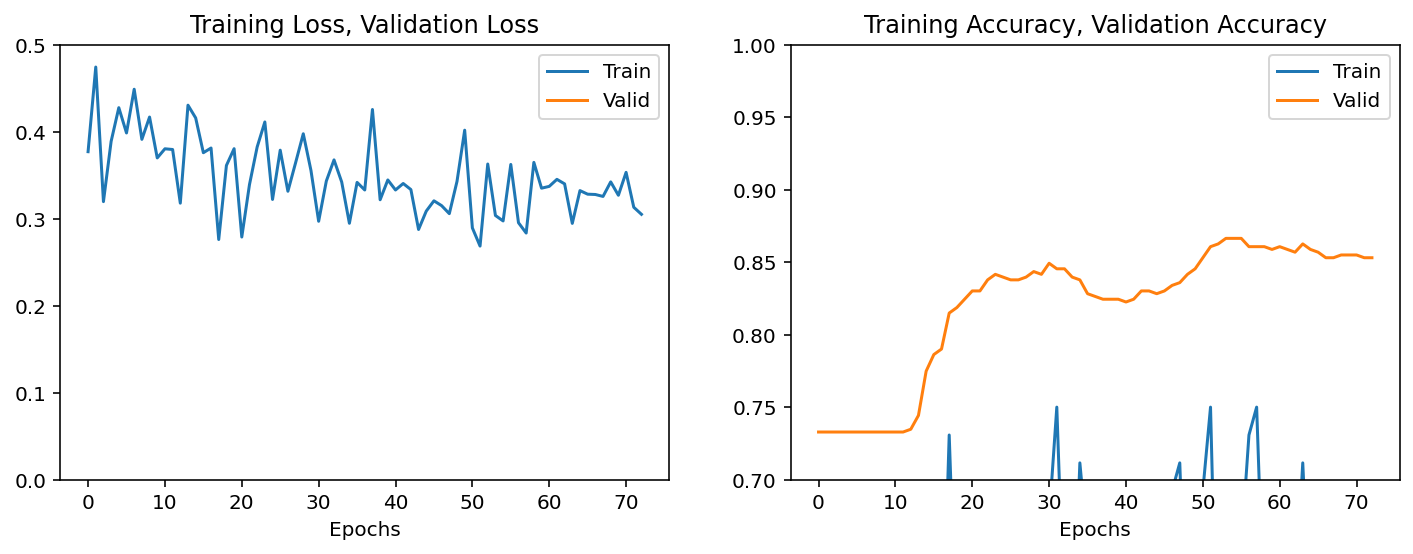

In [22]:
plot_fit()